In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

from utils import *
import os

set_default_style(font_size = 14, axes_labelsize=24, xtick_labelsize=20, ytick_labelsize=20, legend_fontsize=9, legend_title_fontsize=14)

OUTPUT_FOLDER = os.path.join("..", "out", "figures", "encodings")

In [2]:
def morton_encode(x, y, nbits=16):
    morton_code = 0
    for i in range(nbits):
        morton_code |= ((y >> i) & 1) << (2 * i + 1)
        morton_code |= ((x >> i) & 1) << (2 * i)
    return morton_code

def morton_encode_str(x, y, nbits=16):
    morton_code = morton_encode(x, y, nbits)
    return format(morton_code, f'0{nbits*2}b')

def hilbert_encode(x, y, nbits=16):
    x, y = y, x
    d = 0
    s = 1 << (nbits - 1)
    while s:
        rx = 1 if (x & s) > 0 else 0
        ry = 1 if (y & s) > 0 else 0
        d += s * s * ((3 * rx) ^ ry)
        if ry == 0:
            if rx == 1:
                x = s - 1 - x
                y = s - 1 - y
            x, y = y, x
        s //= 2
    return d

def hilbert_encode_str(x, y, nbits=16):
    hilbert_code = hilbert_encode(x, y, nbits)
    return format(hilbert_code, f'0{nbits*2}b')

In [3]:
def plot_quadtree_subdivision(subdivisions_level, mode="morton"):
    grid_size = max(subdivisions_level)**2 * 2
    nbits = int(np.ceil(np.log2(grid_size)))    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(0, grid_size)
    ax.set_ylim(0, grid_size)
    ax.set_aspect('equal', adjustable='box')

    z_curve_path = []

    for i, subdivision in enumerate(subdivisions_level):
        if i == 0:
            start_x, start_y = 0, 0
        elif i == 1:
            start_x, start_y = grid_size // 2, 0
        elif i == 2:
            start_x, start_y = 0, grid_size // 2
        elif i == 3:
            start_x, start_y = grid_size // 2, grid_size // 2

        suboctants = 2**subdivision
        step_size = (grid_size // 2) // suboctants
        
        for x in range(suboctants):
            for y in range(suboctants):
                ax.add_patch(plt.Rectangle(
                    (start_x + x * step_size, start_y + y * step_size), 
                    step_size, step_size, edgecolor='black', facecolor='none', lw=1
                ))

                rel_x = y * (2**(nbits - subdivision - 1)) + start_x
                rel_y = x * (2**(nbits - subdivision - 1)) + start_y
                code_str = 0
                if i == 0 or mode == "morton":
                    code_str = morton_encode_str(rel_y, rel_x, nbits) if mode == "morton" else hilbert_encode_str(rel_y, rel_x, nbits)
                else:
                    code_str = morton_encode_str(rel_x, rel_y, nbits) if mode == "morton" else hilbert_encode_str(rel_x, rel_y, nbits)
                # print(code_str)
                if mode != "morton":
                    if code_str == "011110":
                        code_str = "010100"
                    elif code_str == "010100":
                        code_str = "011100"
                    elif code_str == "111100":
                        code_str = "110100"
                    elif code_str == "110110":
                        code_str = "111100"
                ax.text(start_x + x * step_size + step_size / 2, 
                        start_y + y * step_size + step_size / 2, 
                        code_str[:(subdivision+1)*2], 
                        color='black', 
                        ha='center', 
                        va='center', 
                        fontsize=14 + 16 * (2 - subdivision))
                code = morton_encode(rel_x, rel_y, nbits) if mode == "morton" else hilbert_encode(rel_x, rel_y, nbits)
                z_curve_path.append((rel_x + step_size / 2, rel_y + step_size / 2, code))

    z_curve_path.sort(key=lambda point: point[2])

    z_curve_x = [point[0] for point in z_curve_path]
    z_curve_y = [point[1] for point in z_curve_path]

    segments = []
    colors = []

    for i in range(len(z_curve_x) - 1):
        segments.append([(z_curve_x[i], z_curve_y[i]), (z_curve_x[i + 1], z_curve_y[i + 1])])
        colors.append(i / len(z_curve_x))

    lc = LineCollection(segments, cmap='viridis', norm=plt.Normalize(0, 1), linewidth=4, alpha=0.6, capstyle="round")
    lc.set_array(np.array(colors))
    ax.add_collection(lc)
    return fig

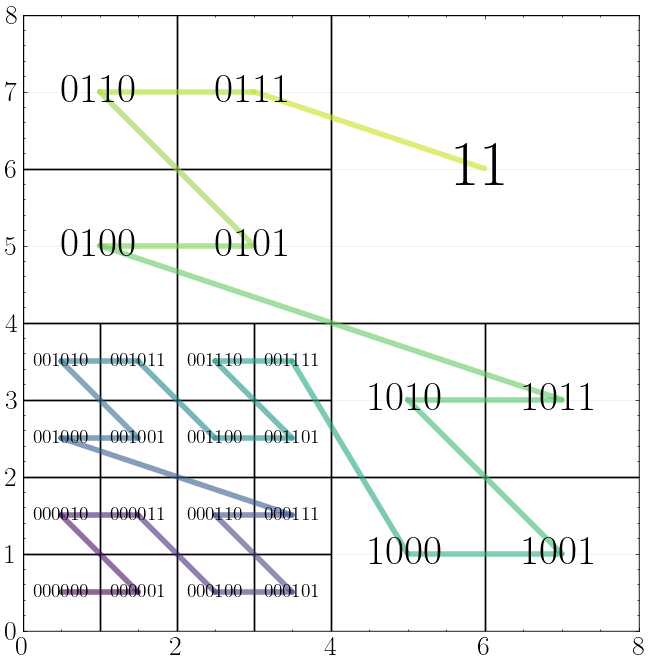

In [4]:
fig = plot_quadtree_subdivision(subdivisions_level=[2, 1, 1, 0], mode = "morton")
output_fig(fig, OUTPUT_FOLDER, f"morton_quadtree")
fig

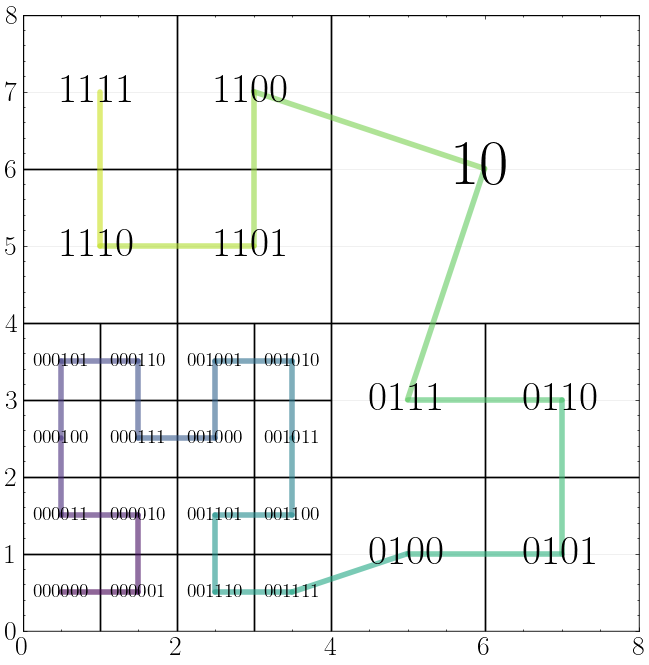

In [5]:
fig = plot_quadtree_subdivision(subdivisions_level=[2, 1, 1, 0], mode = "hilbert")
output_fig(fig, OUTPUT_FOLDER, f"hilber_quadtree")
fig

In [6]:
### NOT USED IN THE PAPER ###
def plot_colored_points_with_subgrids(colors = None, markers = None, subdiv=0, name="plot_cloud_2d"):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(0, 8)
    ax.set_ylim(0, 8)
    ax.set_aspect('equal', adjustable='box')

    # Outer border
    ax.plot([0, 8, 8, 0, 0], [0, 0, 8, 8, 0], 'k-', linewidth=3)

    # Optional: light internal grid lines (1x1)
    for x in range(8):
        rect = patches.Rectangle((x, 0), 0, 8, linewidth=0.5, edgecolor='gray', facecolor='none', linestyle = ":")
        ax.add_patch(rect)
    for y in range(8):
        rect = patches.Rectangle((0, y), 8, 0, linewidth=0.5, edgecolor='gray', facecolor='none', linestyle = ":")
        ax.add_patch(rect)
    # Thicker subdivision lines
    if subdiv >= 1:
        # 4x4 grid lines
        ax.plot([4, 4], [0, 8], 'k-', linewidth=1.5)
        ax.plot([0, 8], [4, 4], 'k-', linewidth=1.5)
    if subdiv == 2:
        # 2x2 grid lines
        for i in [2, 4]:
            ax.plot([i, i], [0, 4], 'k-', linewidth=1)
            ax.plot([0, 4], [i, i], 'k-', linewidth=1)

    # Points and colors
    points = [(0, 0), (1, 0), (3, 1), (1, 3), (2, 5), (6, 1), (6, 6)]
    for i, (x, y) in enumerate(points):
        color = 'black'
        marker = 'o'

        if colors is not None:
            color = colors[i]
        if markers is not None:
            marker = markers[i]

        ax.plot(x + 0.5, y + 0.5, marker=marker, color=color, markersize=10)

    # Ticks and axis labels
    ax.set_xticks(range(0, 8))
    ax.set_yticks(range(0, 8))
    ax.minorticks_off()
    ax.tick_params(axis='both', which='both', top=False, bottom=True, left=True, right=False, direction='out')

    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    plt.grid(False)
    return fig



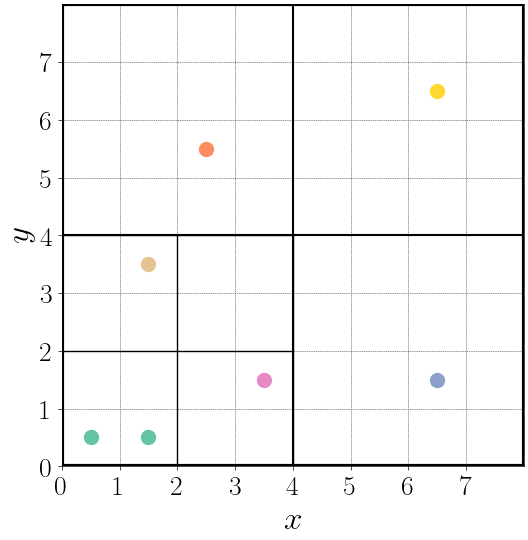

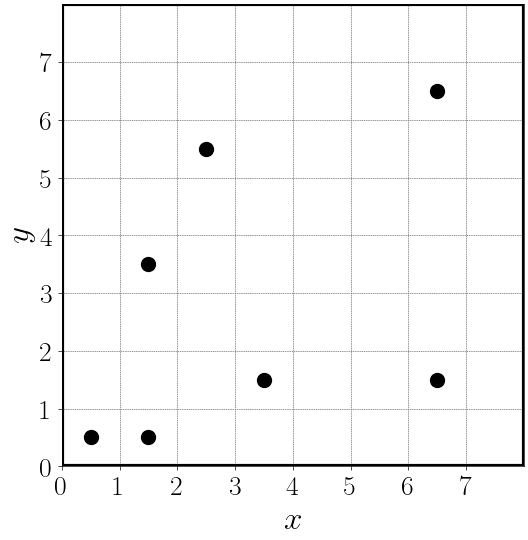

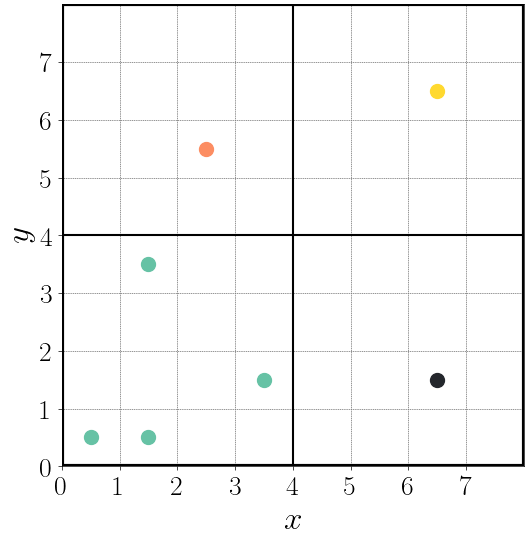

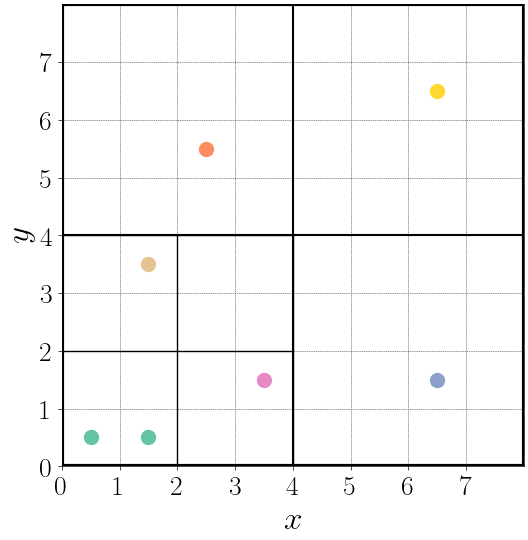

In [7]:
black = ['#000000']*7
plot_colored_points_with_subgrids(black, subdiv=0, name="cloud_subdiv0")

# Set2 palette ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494', '#b3b3b3']
colsub1 = ['#66c2a5','#66c2a5','#66c2a5','#66c2a5', '#fc8d62', "#24272c",  '#ffd92f']
plot_colored_points_with_subgrids(colsub1, subdiv=1, name='cloud_subdiv1')

colsub2 =  ['#66c2a5','#66c2a5','#e78ac3','#e5c494', '#fc8d62', '#8da0cb',  '#ffd92f']
plot_colored_points_with_subgrids(colsub2, subdiv=2, name='cloud_subdiv2')